In [42]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Pipeline: chaininig estimator
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Data imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# Feature Selection/Dimensionality Reduction

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Load dataset, drop row and ID column

In [2]:
all_df = pd.read_excel("./Dataset/trainDataset.xls", sheet_name="Sheet1")
all_df = all_df.drop([218, 253, 285])
dataset_ID = all_df['ID']
all_df.drop('ID', axis=1, inplace=True)

## Data Imputation

In [3]:
missing_values_index = np.where(all_df.isin([999]) == True)
missing_values_index = np.array(missing_values_index)

new_df = all_df.replace(999, np.NaN)
column_names = new_df.columns

k_imp = KNNImputer()
k_imputed_array = k_imp.fit_transform(new_df)

multivariate_imp = IterativeImputer(random_state=42)
multi_imputed_array = multivariate_imp.fit_transform(new_df)

# loop through all the missing values rows and columns and impute the data with round up function
for i in range(len(missing_values_index[0])):
    row = missing_values_index[0][i]
    col = missing_values_index[1][i]
    k_imputed_array[row][col] = np.round(k_imputed_array[row][col])
    multi_imputed_array[row][col] = np.round(multi_imputed_array[row][col])
    print(k_imputed_array[row][col], multi_imputed_array[row][col])

# convert to dataFrame
k_imputed_df = pd.DataFrame(k_imputed_array, columns=column_names)
multi_imputed_df = pd.DataFrame(multi_imputed_array, columns=column_names)

# write imputed dataframe into excel sheet
k_imputed_df.to_excel('./knnImputedDataset.xlsx', sheet_name='Sheet 1', index=False)
multi_imputed_df.to_excel('./multivariateImputedDataset.xlsx', sheet_name='Sheet 1', index=False)

0.0 0.0
3.0 3.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 0.0
1.0 0.0


### Upsampling the shrinked dataset

In [4]:
not_shrink = multi_imputed_df[multi_imputed_df["pCR (outcome)"] == 0]
shrinked  = multi_imputed_df[multi_imputed_df["pCR (outcome)"] == 1]

In [5]:
from sklearn.utils import resample

shrinked = resample(shrinked,
             replace=True,
             n_samples=len(not_shrink),
             random_state=42)

multi_imputed_df = pd.concat([shrinked, not_shrink])

#### Assign independent and dependent variable

In [6]:
# Split the features and target values
X = multi_imputed_df.iloc[:, 2:]

# Target values: pCR (outcome)
classification_target = multi_imputed_df.iloc[:, :1]

#### Data Normalisation

In [7]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

## Feature Selection

In [8]:
import shap

from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

In [9]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (100.0, 100.0)})
plt.rcParams.update({'font.size': 50})

In [10]:
# param_grid = { 
#     'n_estimators': np.arange(200, 500, 100).tolist(),
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : np.arange(4, 15, 1).tolist(),
#     'criterion' :['gini', 'entropy']
# }      
                           
# CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, verbose=3)
# CV_rfc.fit(Xs, classification_target)
# print(CV_rfc.best_params_)

In [11]:
# rf = BalancedRandomForestClassifier(random_state=42, criterion='gini', max_depth=6, max_features='auto',n_estimators=400)
# rf.fit(Xs, classification_target)

### Train test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xs, 
                                                    classification_target,
                                                    stratify=classification_target,
                                                    test_size=0.3, 
                                                    random_state=42)

#### Random Forest Classification (Feature Selection)

In [13]:
# {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 400}
rf = RandomForestClassifier(random_state=42, criterion='gini', max_depth=10, max_features='log2',n_estimators=400)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=400,
                       random_state=42)

In [14]:
# Sort the features
sorted_idx = rf.feature_importances_.argsort()
# Choose number of features to be displayed
num_select_features = 10
sorted_idx = sorted_idx[:num_select_features]

# Display the plot
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Text(0.5, 0, 'Random Forest Feature Importance')

### Permutation Based Feature Importance

In [15]:
perm_importance = permutation_importance(rf, X_test, y_test, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Text(0.5, 0, 'Permutation Importance')

In [16]:
print(list(sorted_idx[0:num_select_features]))
print(X_train)
print(type(X_train))

[98, 92, 27, 103, 99, 10, 43, 85, 6, 110]
[[ 0.76951289 -0.97715849 -0.73353328 ...  1.85169505  1.89883395
  -0.20145412]
 [ 0.36005021 -0.97715849  1.36326467 ... -0.36157967 -0.48670663
  -0.218808  ]
 [-0.05300555  1.02337544 -0.73353328 ... -0.24335688 -0.47563068
  -0.23868032]
 ...
 [-0.22616635  1.02337544  1.36326467 ...  0.14045927 -0.20590364
  -0.23379537]
 [ 0.28420232  1.02337544  1.36326467 ... -0.57102706 -0.61176686
  -0.17874881]
 [-0.70440302 -0.97715849 -0.73353328 ... -1.17725021 -0.72372237
   0.70691992]]
<class 'numpy.ndarray'>


#### Assigned selected feature

In [17]:
sorted_idx = sorted_idx[:num_select_features]

column_header = list(X.columns)
X_train = pd.DataFrame(X_train, columns = column_header)
X_test = pd.DataFrame(X_test, columns = column_header)

column_header = list(X.columns[sorted_idx])
# X_train = X_train.iloc[:, column_header]
# X_test = X_test.iloc[:, column_header]
X_train = X_train[column_header]
X_test = X_test[column_header]
# print(X_train)
# print(sorted_idx)
# print(column_header)
print(X_train)

     original_glszm_GrayLevelVariance  original_glrlm_RunVariance  \
0                            2.132369                   -0.841069   
1                           -0.749558                    1.137270   
2                           -0.921810                   -0.369769   
3                            2.721130                    0.452720   
4                           -0.277948                    0.071370   
..                                ...                         ...   
419                         -0.311234                   -0.471624   
420                         -0.311234                   -0.777440   
421                         -0.801252                    1.290010   
422                         -0.576318                   -0.064188   
423                          0.627757                   -0.588574   

     original_firstorder_Entropy  original_glszm_LowGrayLevelZoneEmphasis  \
0                       1.490687                                -1.450819   
1                

In [18]:
# # Assigned selected feature
# Xs_selected = Xs[:, sorted_idx]

# # Selected feature's Header name
# column_header = X.columns[sorted_idx]

#### Split training and testing data

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(Xs_selected, 
#                                                     classification_target,
#                                                     stratify=classification_target,
#                                                     test_size=0.3, 
#                                                     random_state=42)

## Pipeline

In [20]:
from sklearn.model_selection import GridSearchCV 

# SVC
svc_clf = SVC(random_state=42)
svc_pipeline = make_pipeline(svc_clf)


f_svc_search = GridSearchCV(svc_pipeline,
                            param_grid={'svc__C': np.arange(0, 10, 1).tolist(),
                                       'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                       'svc__degree': np.arange(3, 5, 1).tolist(),
                                       'svc__gamma': ['auto','scale']},
                            scoring='accuracy')


# Logistic Regression
lr_clf = LogisticRegression(random_state=42)
lr_pipeline = make_pipeline(lr_clf)


f_lr_search = GridSearchCV(lr_pipeline,
                            param_grid={'logisticregression__C': np.arange(0, 10, 1).tolist()},
                            scoring='accuracy')


# Balanced Random Forest Classification
brf_clf = BalancedRandomForestClassifier(random_state=42)
brf_pipeline = make_pipeline(brf_clf)

f_brf_search = GridSearchCV(brf_clf,
                            param_grid={'n_estimators': np.arange(200, 500, 100).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'max_depth' : np.arange(4, 15, 1).tolist(),
                                        'criterion' :['gini'],
                                        'sampling_strategy': ['majority'] },
                            scoring='accuracy',
                           verbose=3)


# Random Forest Classification
rf_clf = RandomForestClassifier(random_state=42)
rf_pipeline = make_pipeline(rf_clf)

f_rf_search = GridSearchCV(rf_clf,
                            param_grid={'n_estimators': np.arange(200, 500, 100).tolist(),
                                        'max_features': ['auto', 'sqrt', 'log2'],
                                        'max_depth' : np.arange(4, 15, 1).tolist(),
                                        'criterion' :['gini']},
                            scoring='accuracy',
                           verbose=3)

In [29]:
# SVC
f_svc_search.fit(X_train, y_train)
print("Best parameter for SVC ", f_svc_search.best_params_)
print("Accuracy: ", f_svc_search.best_score_, "\n")

# Logistic Regression
f_lr_search.fit(X_train, y_train)
print("Best parameter for LR ", f_lr_search.best_params_)
print("Accuracy: ", f_lr_search.best_score_, "\n")

# Balanced Random Forest Classification
# f_brf_search.fit(X_train, y_train)
# print("Best parameter for BRF ", f_brf_search.best_params_)
# print("Accuracy: ", f_brf_search.best_score_, "\n")

# Random Forest Classification
f_rf_search.fit(X_train, y_train)
print("Best parameter for LR ", f_rf_search.best_params_)
print("Accuracy: ", f_rf_search.best_score_, "\n")

Best parameter for SVC  {'svc__C': 9, 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Accuracy:  0.7382352941176471 

Best parameter for LR  {'logisticregression__C': 3}
Accuracy:  0.5919887955182073 

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.753 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.671 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.647 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.612 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.702 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.765 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=4, max_features=a

## Confusion Matrix Evaluation

In [30]:
# Figure size settings
plt.rcParams.update({'figure.figsize': (20.0, 20.0)})
plt.rcParams.update({'font.size': 10})

              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68        91
         1.0       0.68      0.64      0.66        91

    accuracy                           0.67       182
   macro avg       0.67      0.67      0.67       182
weighted avg       0.67      0.67      0.67       182



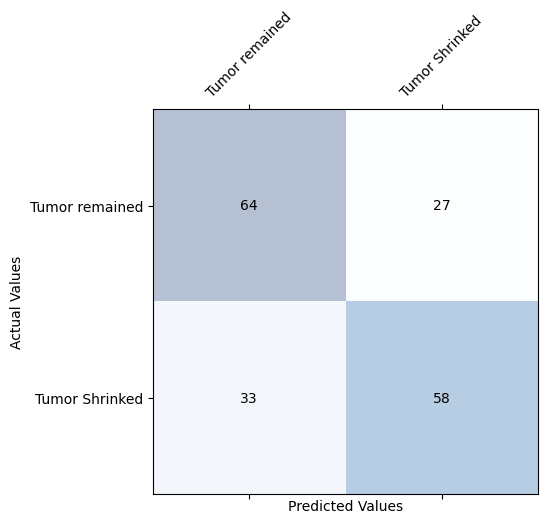

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

svc = SVC(random_state=42, C=9, degree=3, gamma='auto', kernel='rbf')

y_pred = svc.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.51      0.54      0.52        91
         1.0       0.51      0.48      0.50        91

    accuracy                           0.51       182
   macro avg       0.51      0.51      0.51       182
weighted avg       0.51      0.51      0.51       182



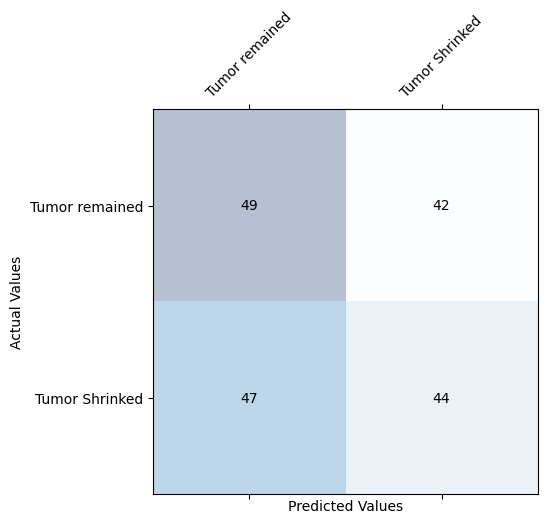

In [32]:
lr = LogisticRegression(random_state=42, C=6)

y_pred = lr.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72        91
         1.0       0.73      0.68      0.70        91

    accuracy                           0.71       182
   macro avg       0.72      0.71      0.71       182
weighted avg       0.72      0.71      0.71       182



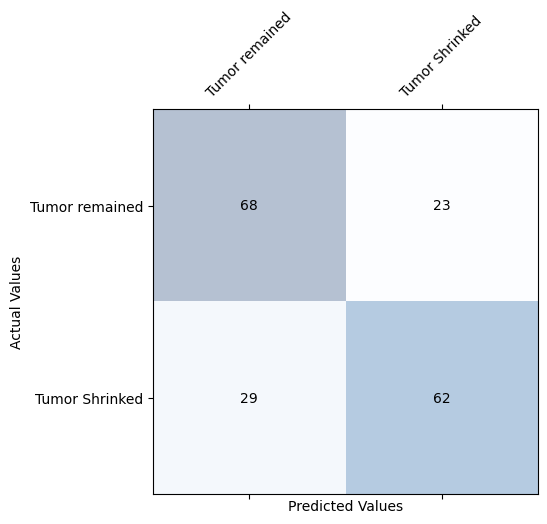

In [33]:
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200, 'sampling_strategy': 'not majority'}
brf= BalancedRandomForestClassifier(random_state=42, criterion='gini', max_depth=4, max_features='auto', n_estimators=200, sampling_strategy='not majority')
y_pred = brf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87        91
         1.0       0.86      0.89      0.88        91

    accuracy                           0.87       182
   macro avg       0.87      0.87      0.87       182
weighted avg       0.87      0.87      0.87       182



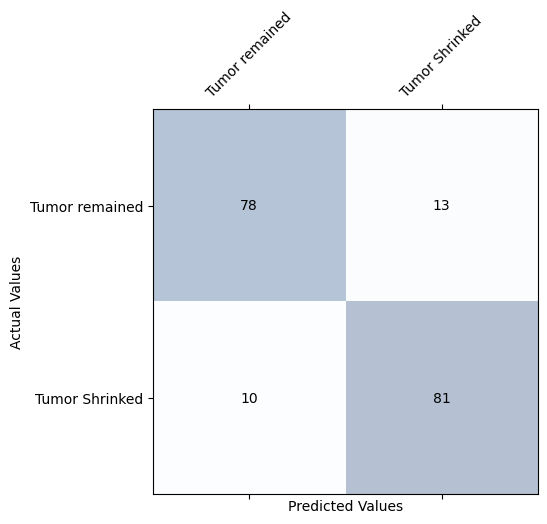

In [37]:
# RFC-FS: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS: {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS (with train/test): (Train and test): {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 300}
# PI-FS (with train/test/upsampling): {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 200}
rf= RandomForestClassifier(random_state=42, criterion='gini', max_depth=12, max_features='auto', n_estimators=200)
y_pred = rf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix,
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["Tumor remained","Tumor Shrinked"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

### K-Fold cross validation

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

models = []
models.append(("Random Forest", rf))

# Test options and evaluation metric
num_folds = 5
num_instances = len(X_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-10s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest: 0.832717 (0.046949)


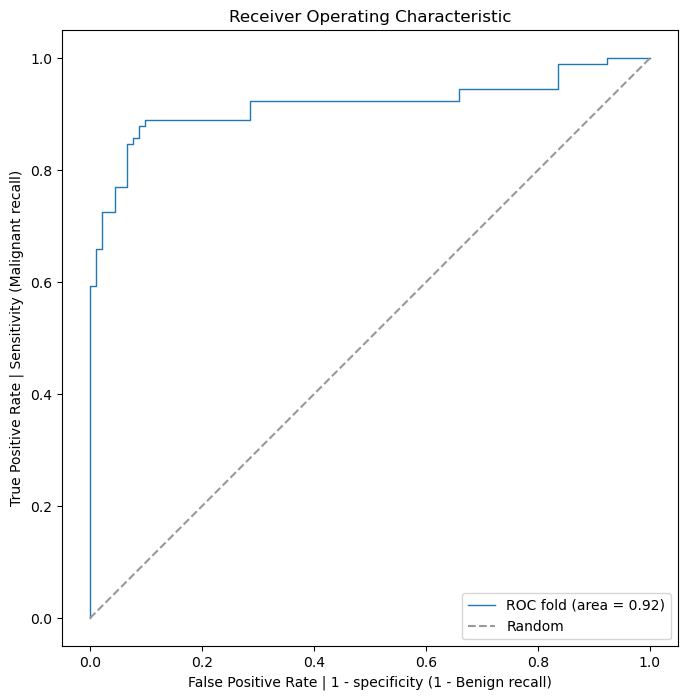

In [41]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
probas_ = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC fold (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate | 1 - specificity (1 - Benign recall)')
plt.ylabel('True Positive Rate | Sensitivity (Malignant recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);